In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

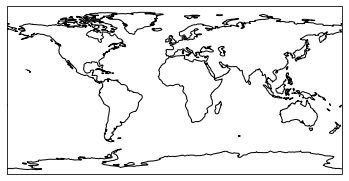

In [2]:
#Make an empty plot with default projection and coastlines
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

In [3]:
file='/shared/obs/gridded/OISSTv2/monthly/sst.mnmean.nc'
ds=xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, nbnds: 2, time: 461)
Coordinates:
  * lat        (lat) float32 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon        (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time       (time) datetime64[ns] 1981-12-01 1982-01-01 ... 2020-04-01
Dimensions without coordinates: nbnds
Data variables:
    sst        (time, lat, lon) float32 ...
    time_bnds  (time, nbnds) datetime64[ns] ...
Attributes:
    title:          NOAA Optimum Interpolation (OI) SST V2
    Conventions:    CF-1.0
    history:        Wed Apr  6 13:47:45 2005: ncks -d time,0,278 SAVEs/sst.mn...
    comments:       Data described in  Reynolds, R.W., N.A. Rayner, T.M.\nSmi...
    platform:       Model
    source:         NCEP Climate Modeling Branch
    institution:    National Centers for Environmental Prediction
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Optimum Interpolation (OI) SST V2
    source_url:     http://www.emc.ncep.noaa.gov/research/cmb/sst_analysis/

## Calculate seasonal means

In [4]:
ds_seas=ds.groupby('time.season').mean()
ds_seas

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, season: 4)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    sst      (season, lat, lon) float32 -1.79 -1.79 -1.79 ... -1.79 -1.79 -1.79

### Plot all 4 seasons on the same figure in a 2x2 configuration

Text(0.5, 0.98, 'SST (degC)')

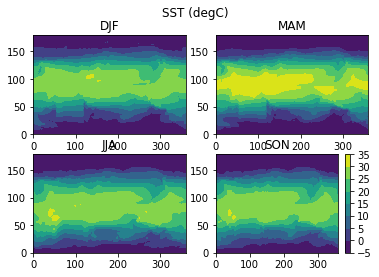

In [5]:
plt.subplot(2,2,1)
plt.contourf(ds_seas['sst'].sel(season='DJF'))
plt.title('DJF')
plt.subplot(2,2,2)
plt.contourf(ds_seas['sst'].sel(season='MAM'))
plt.title('MAM')
plt.subplot(2,2,3)
plt.contourf(ds_seas['sst'].sel(season='JJA'))
plt.title('JJA')
plt.subplot(2,2,4)
plt.contourf(ds_seas['sst'].sel(season='SON'))
plt.title('SON')
plt.colorbar()
plt.suptitle('SST (degC)')

Text(0.5, 0.98, 'SST (deg C)')

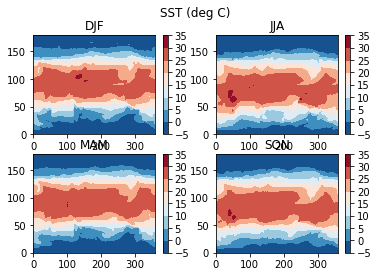

In [6]:
clevs=np.arange(-5,36,5)
for i,seas in enumerate(ds_seas['season']):
    plt.subplot(2,2,i+1)
    plt.contourf(ds_seas['sst'].sel(season=seas),levels=clevs,cmap='RdBu_r')
    plt.title(seas.values)
    plt.colorbar()
plt.suptitle('SST (deg C)')

### What if we want to plot on a map projection?  
Its a little more complicated.
We have to use `plt.subplots`

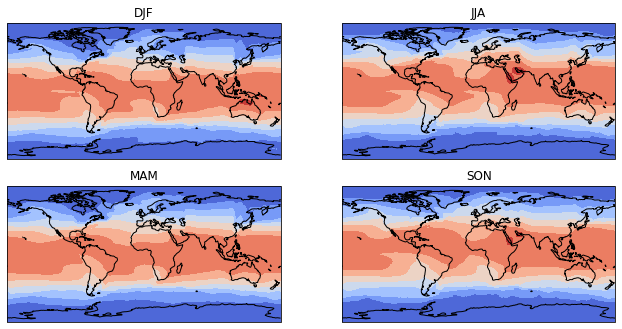

In [7]:
# Define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,5.5))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the seasons and plot
for i,seas in enumerate(ds_seas['season']):

        # Select the season
        data=ds_seas['sst'].sel(season=seas)

        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=ds_seas['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,ds_seas['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='coolwarm',extend='both')

        # Title each subplot with the name of the model
        axs[i].set_title(seas.values)

        # Draw the coastines for each subplot
        axs[i].coastlines()

### Now lets make it look nicer 
* adding a single colorbar 
* add a big title
* label our lats and lons

Text(0.5, 0.98, 'Sea Surface Temperature from OISSTv3')

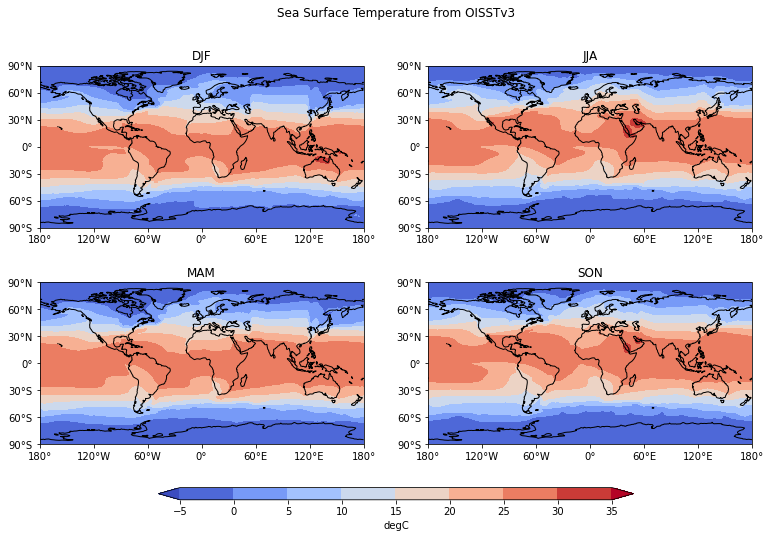

In [8]:
# Define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the seasons and plot
for i,seas in enumerate(ds_seas['season']):

        # Select the season
        data=ds_seas['sst'].sel(season=seas)

        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=ds_seas['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,ds_seas['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='coolwarm',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        # Title each subplot with the name of the season
        axs[i].set_title(seas.values)

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.2)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.175, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='degC')

# Add a big title at the top
plt.suptitle('Sea Surface Temperature from OISSTv3')

### Faceting
This is relatively new for `xarray`, but now that we have the new version available to use we can use it.   It allows you to plot subplots across the dimensios of an `xarray.Dataset` using many fewer lines of code. It uses the metadata to default label the subplots for you and makes a single colorbar for all subplots.
Take a look at the documentation: http://xarray.pydata.org/en/stable/plotting.html
and some nice examples:
https://xarray-contrib.github.io/xarray-tutorial/scipy-tutorial/04_plotting_and_visualization.html

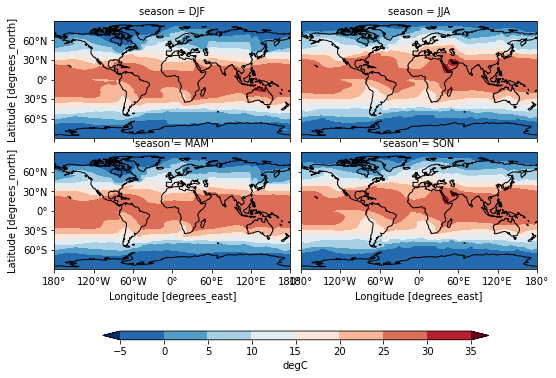

In [9]:
fg = ds_seas['sst'].plot.contourf(
    levels=clevs,
    row='season',
    col_wrap=2,
    robust=True,
    cmap='RdBu_r',
    extend='both',
    subplot_kws={"projection": ccrs.PlateCarree()},
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "label": "degC",
    },
)

for ax in fg.axes.flat:
    ax.coastlines()
    #ax.gridlines(draw_labels=True)
    
    # Longitude labels
    ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)

    # Latitude labels
    ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

### We can also use this faceting capability for animations and interactive plotting using a package called `hvplot`
Learn more: https://hvplot.holoviz.org/user_guide/Gridded_Data.html

In [12]:
import hvplot.xarray 

In [13]:
ds['sst'][0,:,:].hvplot()

:Image   [lon,lat]   (sst)

In [14]:
ds['sst'].hvplot(groupby='time', width=600, widget_type='scrubber', widget_location='bottom')

Column
    [0] HoloViews(DynamicMap, widget_location='bottom', widget_type='scrubber')
    [1] Row
        [0] HSpacer()
        [1] WidgetBox
            [0] Player(end=460, width=550)
        [2] HSpacer()